In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef)

61532

In [7]:
F = (ef['use_record'] == 1)

In [8]:
ef = ef.loc[F]
len(ef)

9320

## Calculate MDRD and add to features table

In [14]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [15]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [16]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

## Create general features table

In [17]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [18]:
## is apache score everr missing?
sum(np.isnan(ef.apsiii))

0

In [21]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = np.isnan(lvsys).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
X['sicu'] = sicu
X['nsicu'] = nsicu
X['micu'] = micu

X.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing,sicu,nsicu,micu
1,0.100055,0.0,0.0,-0.002727,0.0,1.0,0.0,0.436365,0.0,-0.204530,...,0.0,0.0,0.0,1.0,0.0,0.716411,0.0,0.0,1.0,0.0
16,0.450966,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.364830,...,0.0,0.0,0.0,0.0,0.0,3.776100,0.0,0.0,0.0,1.0
20,0.164522,0.0,0.0,0.044261,0.0,0.0,0.0,0.404471,0.0,0.145846,...,1.0,0.0,0.0,0.0,0.0,0.065522,0.0,0.0,0.0,1.0
22,0.305922,0.0,0.0,-0.088287,0.0,0.0,0.0,0.729504,0.0,-1.036671,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0
25,0.390890,0.0,0.0,0.000000,1.0,0.0,0.0,-0.400352,0.0,2.204301,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,1.0


## Some helper model building functions

In [22]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [23]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

## Simple linear model for predicting fluid balance on day 1

In [24]:
## predictive model of fluids given
y_fluid = ef.fb_day1_balance_ml
missing = np.isnan(y_fluid) | ef.fb_day1_balance_truncated
np.sum(missing)

991

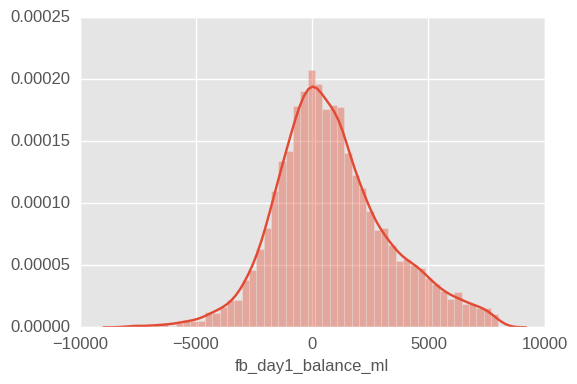

In [25]:
sns.distplot(ef.fb_day1_balance_ml[~missing])

In [26]:
X_fluid = X.loc[~missing]
y_fluid = normalize(y_fluid[~missing])
len(y_fluid)

8329

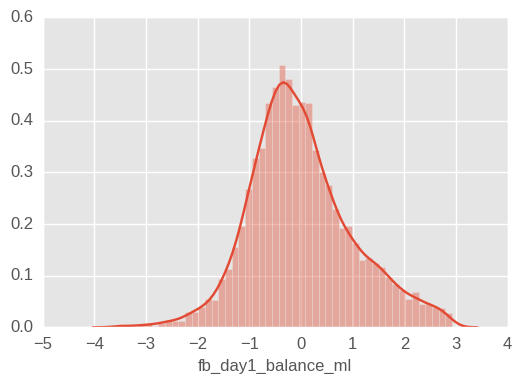

In [27]:
sns.distplot(y_fluid)

In [28]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    ridge(X_fluid, y_fluid)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

         Current function value: 11058.252579
         Iterations: 42
         Function evaluations: 110
         Gradient evaluations: 100


100%|██████████| 2000/2000 [00:34<00:00, 57.59it/s]


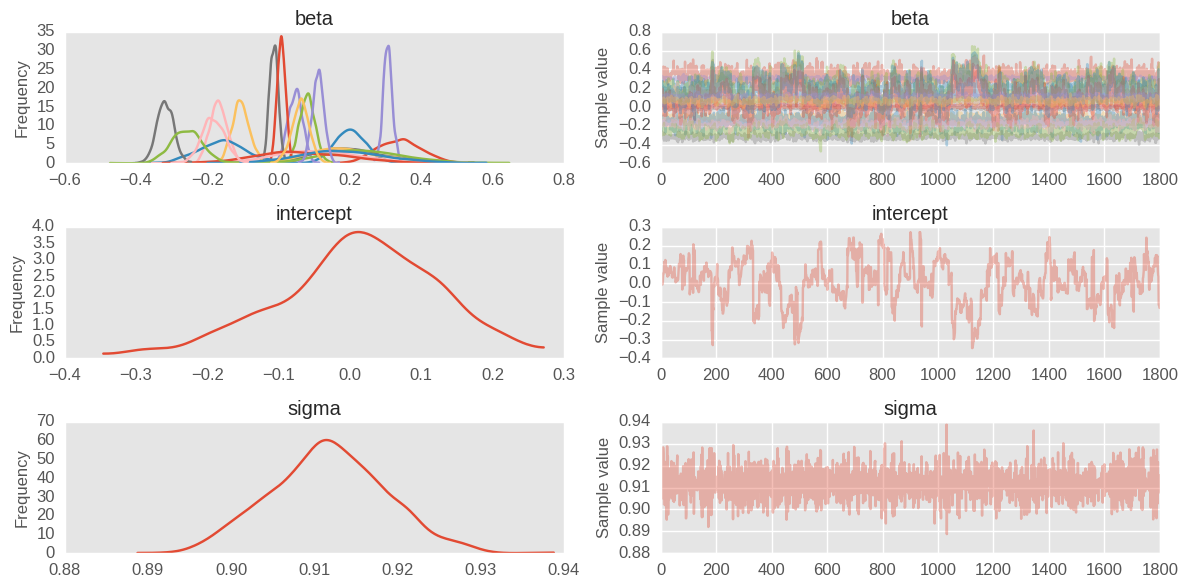

In [29]:
_ = pm.traceplot(trace[200:])

In [30]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_fluid.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing,sicu,nsicu,micu,intercept
0,0.475509,0.190999,0.033812,-0.015555,-0.112109,0.088965,-0.169937,0.011288,-0.126852,0.315863,...,0.153826,0.235415,0.080644,0.159647,0.105738,-0.335348,0.033724,-0.298870,-0.210904,0.034369
1,0.316675,0.270137,0.053106,-0.011916,-0.139282,0.074522,-0.172020,0.000425,-0.213186,0.306515,...,0.304634,0.000017,0.061067,0.185927,0.131799,-0.315479,0.036384,-0.302828,-0.221594,0.056522
2,0.376235,0.269637,0.081932,-0.016543,-0.099098,0.051590,-0.165442,-0.009615,-0.092623,0.287987,...,0.194795,0.019583,-0.004034,0.136136,0.103163,-0.321770,0.067370,-0.260715,-0.213779,0.050884
3,0.374870,0.164508,0.034953,-0.010147,-0.093306,0.109521,-0.199713,0.021215,-0.254280,0.311986,...,0.267077,0.178936,0.148813,0.283241,0.130690,-0.302202,0.057191,-0.276590,-0.174559,0.004900
4,0.374870,0.164508,0.034953,-0.010147,-0.093306,0.109521,-0.199713,0.021215,-0.254280,0.311986,...,0.267077,0.178936,0.148813,0.283241,0.130690,-0.302202,0.057191,-0.276590,-0.174559,0.004900


In [31]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing,sicu,nsicu,micu,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,...,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.340100,0.201609,0.046331,-0.013363,-0.106793,0.079735,-0.168806,0.007573,-0.159010,0.306129,...,0.238833,0.111950,0.066506,0.179626,0.110880,-0.318130,0.061761,-0.258917,-0.183729,0.008450
std,0.062025,0.043890,0.020023,0.011871,0.024036,0.021695,0.023922,0.011467,0.067514,0.012478,...,0.119683,0.122570,0.131233,0.122263,0.016207,0.023312,0.024227,0.043916,0.032301,0.113150
min,0.146162,0.047598,-0.019675,-0.051183,-0.195120,0.007414,-0.274379,-0.035405,-0.408924,0.267902,...,-0.153241,-0.356198,-0.324838,-0.199060,0.056495,-0.402132,-0.020659,-0.472702,-0.300694,-0.345844
25%,0.296529,0.171880,0.032211,-0.021717,-0.122088,0.065497,-0.184479,-0.000391,-0.204224,0.297854,...,0.160703,0.025831,-0.022614,0.098429,0.100652,-0.333721,0.046472,-0.288037,-0.204956,-0.055836
50%,0.341164,0.201249,0.047195,-0.013013,-0.107072,0.080305,-0.169432,0.007573,-0.157980,0.305936,...,0.231853,0.106064,0.059763,0.173010,0.111463,-0.318330,0.062300,-0.258929,-0.184699,0.014989
75%,0.381136,0.230622,0.059503,-0.005454,-0.091353,0.094123,-0.153505,0.015439,-0.114912,0.314073,...,0.313602,0.189319,0.158175,0.258455,0.121895,-0.301366,0.077939,-0.230284,-0.161037,0.088473
max,0.547823,0.341308,0.113461,0.026529,-0.035699,0.149814,-0.080509,0.046465,0.051920,0.351365,...,0.646730,0.530167,0.498286,0.582555,0.169336,-0.245398,0.143974,-0.113105,-0.085881,0.271737


In [32]:
W = sample_coefs.values[:,:X_fluid.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_fluid.values, W.T) + b
y_ppc = y_ppc.T

In [33]:
r2_ppc = np.zeros(len(y_ppc))
for i in range(len(y_ppc)):
    yh = y_ppc[i]
    r = pearsonr(yh, y_fluid)[0]
    r2_ppc[i] = r**2

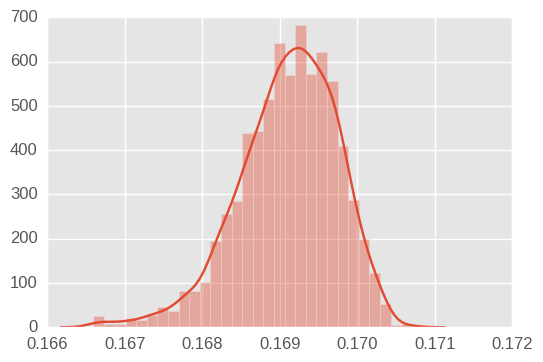

In [34]:
sns.distplot(r2_ppc)

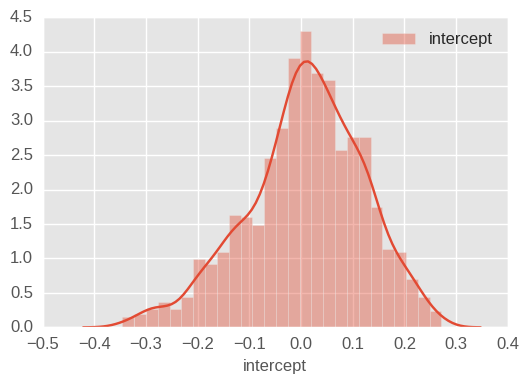

In [35]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.340100,0.201609,0.046331,-0.013363,-0.106793
std,0.062025,0.043890,0.020023,0.011871,0.024036
min,0.146162,0.047598,-0.019675,-0.051183,-0.195120
25%,0.296529,0.171880,0.032211,-0.021717,-0.122088
50%,0.341164,0.201249,0.047195,-0.013013,-0.107072
75%,0.381136,0.230622,0.059503,-0.005454,-0.091353
max,0.547823,0.341308,0.113461,0.026529,-0.035699


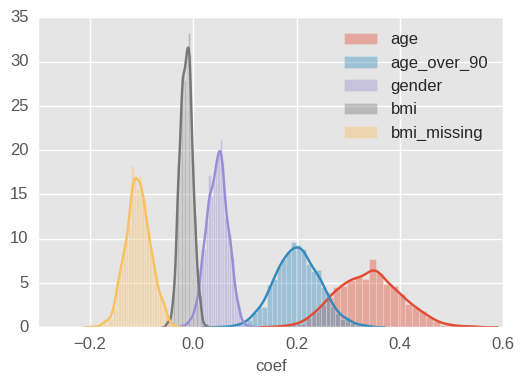

In [36]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.079735,-0.168806,0.306129,0.007573,-0.159010,0.110880,-0.318130
std,0.021695,0.023922,0.012478,0.011467,0.067514,0.016207,0.023312
min,0.007414,-0.274379,0.267902,-0.035405,-0.408924,0.056495,-0.402132
25%,0.065497,-0.184479,0.297854,-0.000391,-0.204224,0.100652,-0.333721
50%,0.080305,-0.169432,0.305936,0.007573,-0.157980,0.111463,-0.318330
75%,0.094123,-0.153505,0.314073,0.015439,-0.114912,0.121895,-0.301366
max,0.149814,-0.080509,0.351365,0.046465,0.051920,0.169336,-0.245398


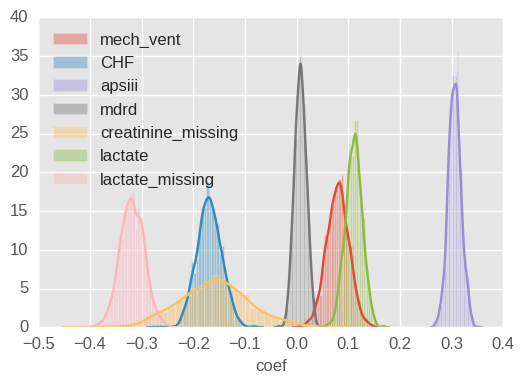

In [37]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,micu,sicu,nsicu
count,1800.000000,1800.000000,1800.000000
mean,-0.183729,0.061761,-0.258917
std,0.032301,0.024227,0.043916
min,-0.300694,-0.020659,-0.472702
25%,-0.204956,0.046472,-0.288037
50%,-0.184699,0.062300,-0.258929
75%,-0.161037,0.077939,-0.230284
max,-0.085881,0.143974,-0.113105


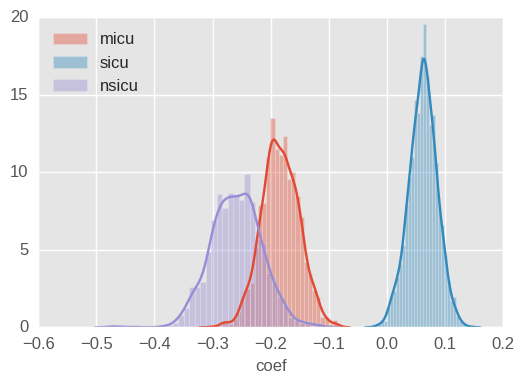

In [38]:
coefs = ['micu', 'sicu', 'nsicu']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.202879,0.188235,0.238833,0.111950,0.066506,0.179626
std,0.104520,0.106604,0.119683,0.122570,0.131233,0.122263
min,-0.107092,-0.151528,-0.153241,-0.356198,-0.324838,-0.199060
25%,0.132065,0.116334,0.160703,0.025831,-0.022614,0.098429
50%,0.193470,0.179221,0.231853,0.106064,0.059763,0.173010
75%,0.264179,0.252007,0.313602,0.189319,0.158175,0.258455
max,0.546961,0.552339,0.646730,0.530167,0.498286,0.582555


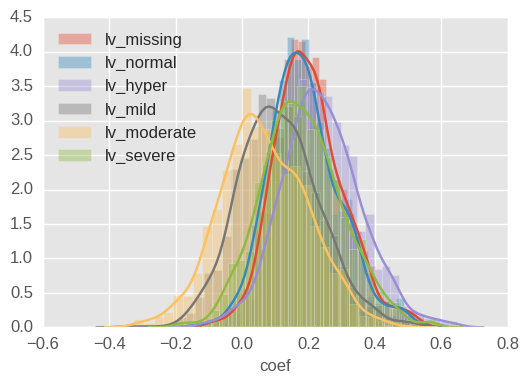

In [39]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

## Simple linear model for predicting 30-day mortality

In [40]:
## make the features table. include fluid balance on days 1,2,3 of ICU stay
X_mortality = X.copy()

fluid_day1 = ef.fb_day1_balance_ml.values
fl_missing = np.isnan(fluid_day1) | ef.fb_day1_balance_truncated.eq(1).values # also filter insane fluid balances
fluid_day1[~fl_missing] = normalize(fluid_day1[~fl_missing])
fluid_day1[fl_missing] = 0
X_mortality['fluid_day1'] = fluid_day1
X_mortality['fluid_day1_missing'] = fl_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
fl_missing = np.isnan(fluid_day2) | ef.fb_day2_balance_truncated.eq(1).values
fluid_day2[~fl_missing] = normalize(fluid_day2[~fl_missing])
fluid_day2[fl_missing] = 0
X_mortality['fluid_day2'] = fluid_day2
X_mortality['fluid_day2_missing'] = fl_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
fl_missing = np.isnan(fluid_day3) | ef.fb_day3_balance_truncated.eq(1).values
fluid_day3[~fl_missing] = normalize(fluid_day3[~fl_missing])
fluid_day3[fl_missing] = 0
X_mortality['fluid_day3'] = fluid_day3
X_mortality['fluid_day3_missing'] = fl_missing.astype(float)

In [41]:
y_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')
y_mortality = y_mortality.astype(float)
y_mortality.mean(), y_mortality.sum(), len(y_mortality)

(0.2811158798283262, 2620.0, 9320)

In [42]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    logistic(X_mortality, y_mortality)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 4594.517909
         Iterations: 41
         Function evaluations: 96
         Gradient evaluations: 95


100%|██████████| 2000/2000 [03:36<00:00,  9.25it/s]


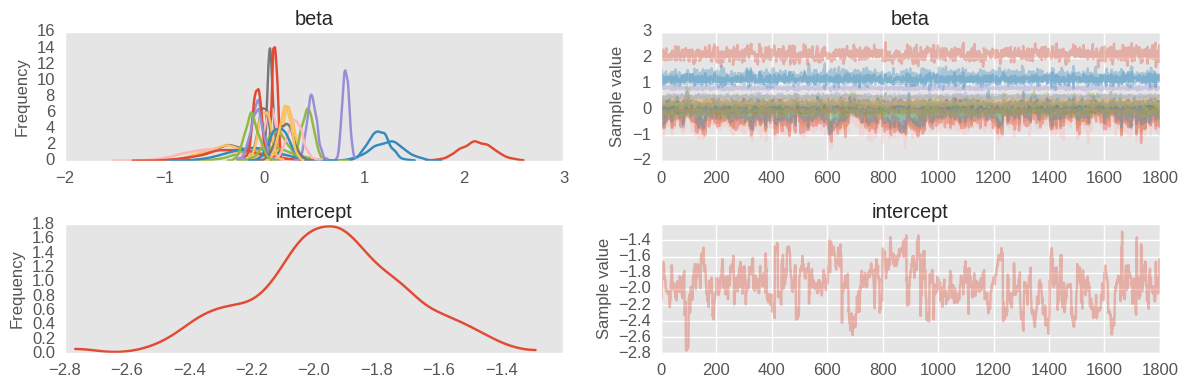

In [43]:
_ = pm.traceplot(trace[200:])

In [44]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_mortality.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,sicu,nsicu,micu,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
0,2.125002,1.091786,-0.172572,0.097342,0.220225,0.448283,0.102544,0.160274,0.877921,0.867865,...,0.005621,-0.078785,0.252588,0.023231,0.350200,-0.129738,0.169905,0.171489,-0.102489,-2.122258
1,2.125002,1.091786,-0.172572,0.097342,0.220225,0.448283,0.102544,0.160274,0.877921,0.867865,...,0.005621,-0.078785,0.252588,0.023231,0.350200,-0.129738,0.169905,0.171489,-0.102489,-2.122258
2,2.075760,0.971937,-0.159110,0.121336,0.246695,0.408107,0.100855,0.180099,0.941827,0.879164,...,-0.020573,-0.048914,0.285718,0.003042,0.280880,-0.108942,0.126332,0.179380,-0.118190,-2.130577
3,2.224053,1.351049,-0.079503,0.029077,0.232937,0.394664,0.021071,0.075165,1.541294,0.838394,...,-0.036813,0.137940,0.213698,-0.095286,0.187042,-0.089387,0.216516,0.220580,-0.162277,-2.027479
4,2.101253,0.959459,-0.074007,0.080547,0.276626,0.467314,0.084836,0.130306,0.917979,0.792403,...,0.007455,0.075635,0.275974,-0.057671,0.112864,-0.035364,0.179140,0.195737,-0.132656,-1.686236


In [45]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,sicu,nsicu,micu,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,...,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.130584,1.146753,-0.069340,0.062112,0.239174,0.435049,0.066865,0.105024,1.235480,0.816776,...,0.003091,0.119187,0.307097,-0.071299,0.155473,-0.074656,0.205859,0.211355,-0.122574,-1.954065
std,0.164235,0.104489,0.052490,0.031078,0.060099,0.059171,0.059378,0.025729,0.163041,0.033153,...,0.059484,0.110601,0.080093,0.041245,0.091252,0.063693,0.081829,0.058363,0.070345,0.243889
min,1.624915,0.836881,-0.257514,-0.032090,0.029263,0.247150,-0.114655,0.023638,0.715357,0.714150,...,-0.205071,-0.266479,0.032375,-0.188895,-0.150315,-0.274296,-0.075802,0.025203,-0.363610,-2.766214
25%,2.017244,1.075997,-0.105143,0.041710,0.200890,0.394112,0.026669,0.087714,1.121707,0.793941,...,-0.039232,0.046453,0.254724,-0.099994,0.090856,-0.115174,0.149272,0.173107,-0.168764,-2.098164
50%,2.126923,1.146413,-0.068496,0.059646,0.239226,0.435698,0.067440,0.105180,1.242260,0.816242,...,0.002851,0.119958,0.307224,-0.070723,0.154934,-0.072316,0.208755,0.212307,-0.125077,-1.946661
75%,2.243347,1.215353,-0.034718,0.080061,0.279487,0.475841,0.105850,0.123276,1.346588,0.839777,...,0.045149,0.191941,0.359522,-0.041855,0.216577,-0.033636,0.262076,0.252034,-0.076439,-1.796270
max,2.599525,1.508449,0.182407,0.206333,0.445452,0.660533,0.285961,0.195493,1.774297,0.911396,...,0.188365,0.478841,0.577668,0.083051,0.461201,0.140079,0.490435,0.392441,0.128336,-1.289641


In [46]:
W = sample_coefs.values[:,:X_mortality.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_mortality.values, W.T) + b
y_ppc = y_ppc.T
y_ppc.shape, y_mortality.shape

((1800, 9320), (9320,))

In [47]:
acc_ppc = (y_ppc > 0).astype(float) == y_mortality.values
acc_ppc = acc_ppc.mean(axis=1)

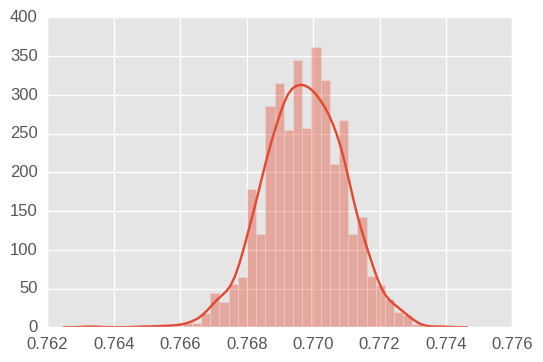

In [48]:
sns.distplot(acc_ppc)

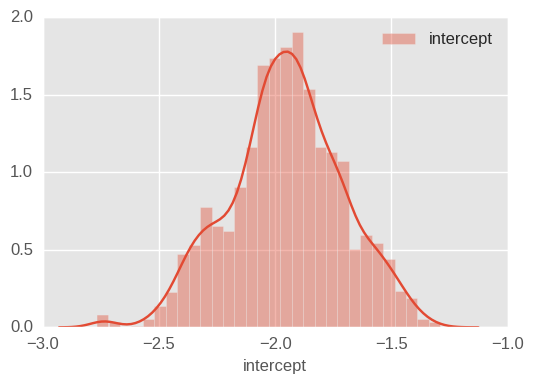

In [49]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.130584,1.146753,-0.069340,0.062112,0.239174
std,0.164235,0.104489,0.052490,0.031078,0.060099
min,1.624915,0.836881,-0.257514,-0.032090,0.029263
25%,2.017244,1.075997,-0.105143,0.041710,0.200890
50%,2.126923,1.146413,-0.068496,0.059646,0.239226
75%,2.243347,1.215353,-0.034718,0.080061,0.279487
max,2.599525,1.508449,0.182407,0.206333,0.445452


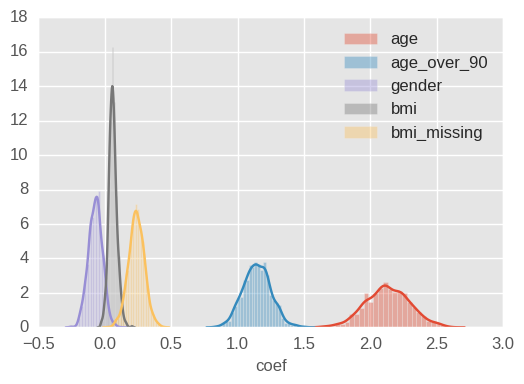

In [50]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.435049,0.066865,0.816776,0.105024,1.235480,0.479126,-0.001930
std,0.059171,0.059378,0.033153,0.025729,0.163041,0.049095,0.057474
min,0.247150,-0.114655,0.714150,0.023638,0.715357,0.302342,-0.200467
25%,0.394112,0.026669,0.793941,0.087714,1.121707,0.446684,-0.040435
50%,0.435698,0.067440,0.816242,0.105180,1.242260,0.478165,-0.001795
75%,0.475841,0.105850,0.839777,0.123276,1.346588,0.512332,0.036090
max,0.660533,0.285961,0.911396,0.195493,1.774297,0.635239,0.169772


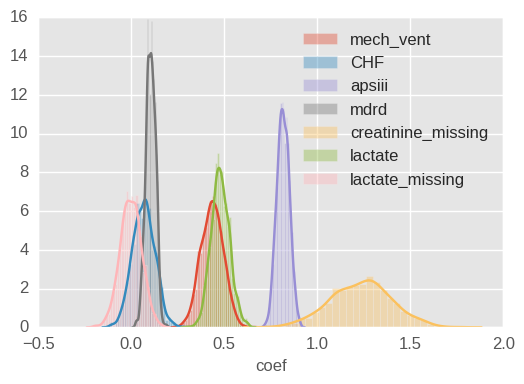

In [51]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,micu,sicu,nsicu
count,1800.000000,1800.000000,1800.000000
mean,0.307097,0.003091,0.119187
std,0.080093,0.059484,0.110601
min,0.032375,-0.205071,-0.266479
25%,0.254724,-0.039232,0.046453
50%,0.307224,0.002851,0.119958
75%,0.359522,0.045149,0.191941
max,0.577668,0.188365,0.478841


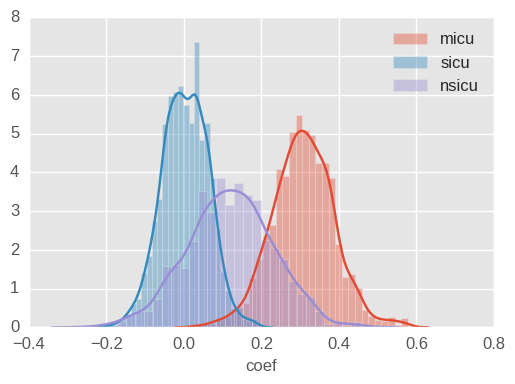

In [55]:
coefs = ['micu', 'sicu', 'nsicu']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.365930,-0.398255,0.023501,-0.546818,-0.318722,-0.118381
std,0.208681,0.212698,0.237792,0.269281,0.281499,0.251157
min,-0.942436,-1.017176,-0.729527,-1.514358,-1.317447,-0.966918
25%,-0.505656,-0.545169,-0.140310,-0.731296,-0.503888,-0.288808
50%,-0.359405,-0.389797,0.031060,-0.546377,-0.311637,-0.113648
75%,-0.219833,-0.256753,0.180409,-0.359075,-0.128474,0.048859
max,0.261590,0.207386,0.851239,0.286240,0.555492,0.728048


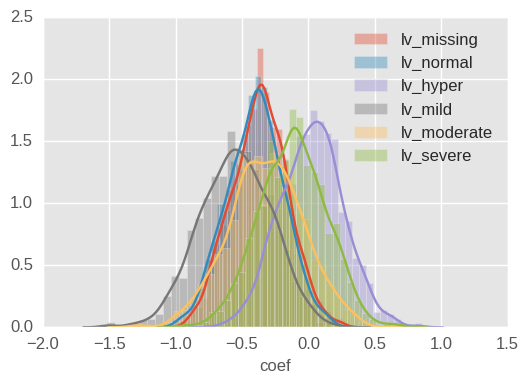

In [52]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1,fluid_day2,fluid_day3
count,1800.000000,1800.000000,1800.000000
mean,-0.071299,-0.074656,0.211355
std,0.041245,0.063693,0.058363
min,-0.188895,-0.274296,0.025203
25%,-0.099994,-0.115174,0.173107
50%,-0.070723,-0.072316,0.212307
75%,-0.041855,-0.033636,0.252034
max,0.083051,0.140079,0.392441


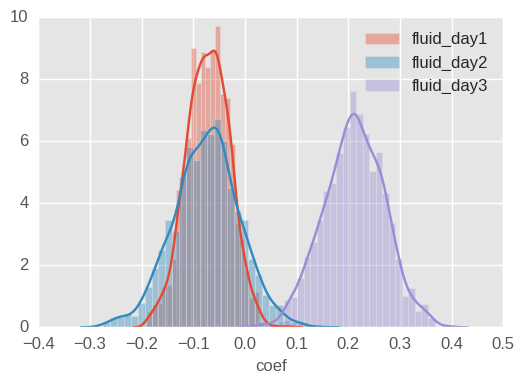

In [53]:
coefs = ['fluid_day1', 'fluid_day2', 'fluid_day3']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1_missing,fluid_day2_missing,fluid_day3_missing
count,1800.000000,1800.000000,1800.000000
mean,0.155473,0.205859,-0.122574
std,0.091252,0.081829,0.070345
min,-0.150315,-0.075802,-0.363610
25%,0.090856,0.149272,-0.168764
50%,0.154934,0.208755,-0.125077
75%,0.216577,0.262076,-0.076439
max,0.461201,0.490435,0.128336


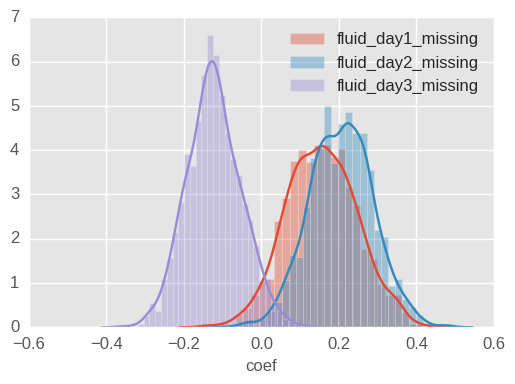

In [54]:
coefs = ['fluid_day1_missing', 'fluid_day2_missing', 'fluid_day3_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')